In [246]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

## Importance features: 'COMPOSITE_INDEX', 'GROCERY_ITEMS', 'HOUSING', 'UTILITIES', 'TRANSPORTATION', 'HEALTH_CARE', 'MISC_GOODS_SERVICES'

# Read excel data to dataframe
data = pd.read_excel('COLI Historical Data - 1990 Q1 - 2024 Q3.xlsx')


In [247]:
## Check datatype and cleaning

# # Check data type for each column 
# for col, dtype in data.dtypes.items():
#     print(f"{dtype} - {col}")

# Replace null values in columns starting from 'COMPOSITE_INDEX'
start_index = data.columns.get_loc('COMPOSITE_INDEX')
for col in data.iloc[:, start_index:]:
    # convert column to numbers (float)
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
    if data[col].isna().any():
        year_state_mean = data.groupby(['YEAR', 'STATE_NAME'])[col].transform('mean')
        data.fillna({col: year_state_mean}, inplace=True)
        
        year_mean = data.groupby('YEAR')[col].transform('mean')
        data.fillna({col: year_mean}, inplace=True)
        
        overall_mean = data[col].mean()
        data.fillna({col: overall_mean}, inplace=True)

    # print(f"{col}: total: {len(data[col])} null: {data[col].isna().sum()}")



In [248]:
## Calculate correlation coefficients for each important feature with target variable 'COMPOSITE_INDEX'

important_features = data[['COMPOSITE_INDEX', 'GROCERY_ITEMS', 'HOUSING', 'UTILITIES', 'TRANSPORTATION', 'HEALTH_CARE', 'MISC_GOODS_SERVICES']]

# Calculate the correlation matrix
correlation_matrix = important_features.corr()

# Extract the correlation of each feature with the target variable (composite_index)
correlation_with_target = correlation_matrix['COMPOSITE_INDEX'].sort_values(ascending=False)

# Print the correlation coefficients
print(correlation_with_target)

## Above prints the following:
# COMPOSITE_INDEX        1.000000
# HOUSING                0.964540
# MISC_GOODS_SERVICES    0.792042
# GROCERY_ITEMS          0.755331
# TRANSPORTATION         0.609652
# HEALTH_CARE            0.568614
# UTILITIES              0.449028

# Interpretation:
# HOUSING, MISC_GOODS_SERVICES and GROCERY_ITEMS have stronger correlation relationship with 'COMPOSITE_INDEX' than the remaining 3 features 

COMPOSITE_INDEX        1.000000
HOUSING                0.964540
MISC_GOODS_SERVICES    0.792042
GROCERY_ITEMS          0.755331
TRANSPORTATION         0.609652
HEALTH_CARE            0.568614
UTILITIES              0.449028
Name: COMPOSITE_INDEX, dtype: float64


In [249]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

## Use Random Forest to rank the importance of features based on their contribution to predicting the cost of living index.

X = data[['GROCERY_ITEMS', 'HOUSING', 'UTILITIES', 'TRANSPORTATION', 'HEALTH_CARE', 'MISC_GOODS_SERVICES']]
y = data[['COMPOSITE_INDEX']]

# Initialize and fit the Random Forest Regressor model
rf_model = RandomForestRegressor()
rf_model.fit(X, np.ravel(y))

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances ranking list
pd.DataFrame(data={'feature': X.columns,'importance': feature_importances}).sort_values('importance', ascending=False)

# HOUSING    0.930885
# MISC_GOODS_SERVICES    0.039324
# UTILITIES    0.013022
# GROCERY_ITEMS    0.009617
# TRANSPORTATION    0.004049
# HEALTH_CARE    0.003104

,feature,importance
1,HOUSING,0.930532
5,MISC_GOODS_SERVICES,0.039420
2,UTILITIES,0.013292
0,GROCERY_ITEMS,0.009532
3,TRANSPORTATION,0.004119
4,HEALTH_CARE,0.003104


Outliers:     YEAR  COMPOSITE_INDEX
1   1991       100.150226
4   1994       100.073071
23  2013        99.466450
Skewness: -0.49913571264059264
Min Composite Index: 99.92720794602077
Max Composite Index: 100.00881091940222
Mean Absolute Error (MAE): 0.00746763911854649
R² score: 0.7605765531821017


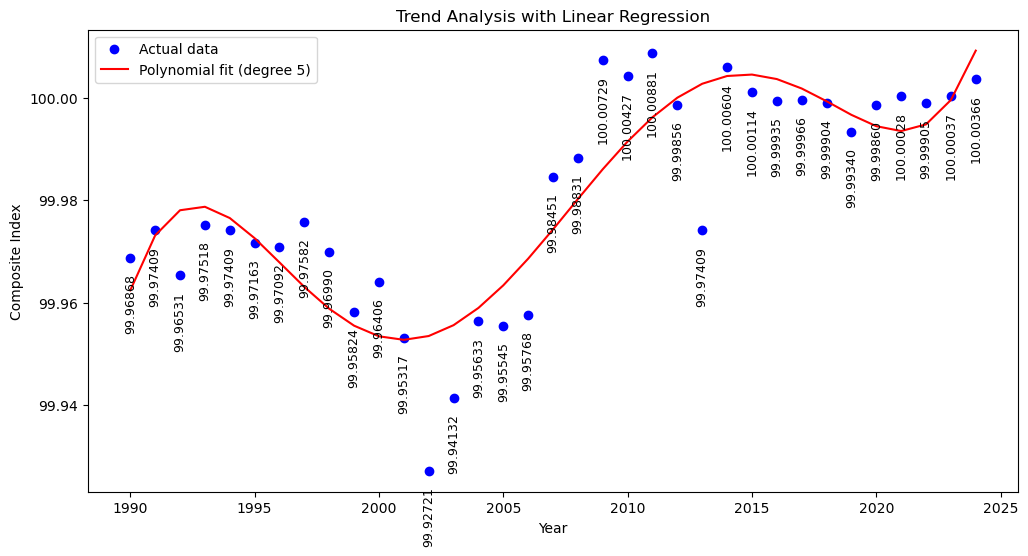

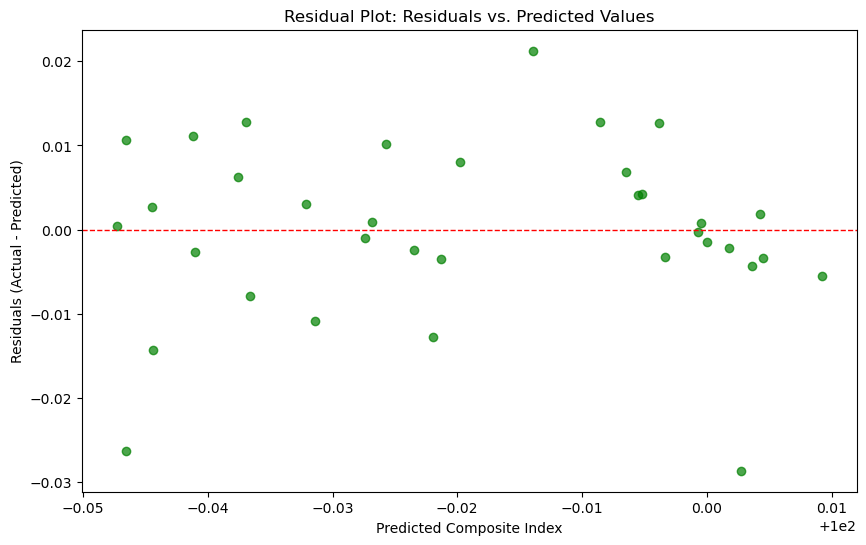

In [250]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

## Use Linear Regression model with degree 5 polynomial fit to predict trends in COMPOSITE_INDEX over time (YEAR)

# Aggregate data by year
composite_index_by_year = data.groupby(['YEAR'])['COMPOSITE_INDEX'].mean().reset_index()

# Get outliers
q1 = composite_index_by_year['COMPOSITE_INDEX'].quantile(0.25)
q3 = composite_index_by_year['COMPOSITE_INDEX'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = composite_index_by_year[
    (composite_index_by_year['COMPOSITE_INDEX'] < lower_bound) | 
    (composite_index_by_year['COMPOSITE_INDEX'] > upper_bound)
]
print("Outliers:", outliers)

# Replace outliers with mean 
composite_index_by_year.loc[
    (composite_index_by_year['COMPOSITE_INDEX'] < lower_bound) | 
    (composite_index_by_year['COMPOSITE_INDEX'] > upper_bound), 'COMPOSITE_INDEX'
] = composite_index_by_year['COMPOSITE_INDEX'].mean()

# COMPOSITE_INDEX distribution (skewness)
skewness = skew(composite_index_by_year['COMPOSITE_INDEX'])
print(f"Skewness: {skewness}") # -0.4991 (slightly negatively skewed but relatively close to symmetric - 0)

print("Min Composite Index:", composite_index_by_year['COMPOSITE_INDEX'].min())   # 99.9272
print("Max Composite Index:", composite_index_by_year['COMPOSITE_INDEX'].max())   # 100.0088

X = composite_index_by_year[['YEAR']].values
y = composite_index_by_year['COMPOSITE_INDEX'].values

deg = 5
poly = PolynomialFeatures(degree=deg)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Initialize and fit Linear Regression model
model = LinearRegression()
model.fit(X_poly_scaled, y)

# Predict the trend
trend = model.predict(X_poly_scaled)

# Calculate Mean Absolute Error (MAE) 
mae = mean_absolute_error(y, trend)
print("Mean Absolute Error (MAE):", mae)   # 0.0443

# Calculate R-square
r2 = model.score(X_poly_scaled, y)
print("R² score:", r2)

# Visualize the trend
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, trend, color='red', label=f'Polynomial fit (degree {deg})')

# Annotate each point in the scatter plot
for i, value in enumerate(y):
    plt.text(X[i], y[i] - 0.003, f'{value:.5f}', ha='center', va='top', fontsize=9, rotation=90)
    
plt.xlabel('Year')
plt.ylabel('Composite Index')
plt.title('Trend Analysis with Linear Regression')
plt.legend()
plt.show()

# Calculate residuals (difference between actual value and predicted value)
residuals = y - trend

# Plot the residuals vs. Predicted Values (trend)
plt.figure(figsize=(10, 6))
plt.scatter(trend, residuals, color='green', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot: Residuals vs. Predicted Values")
plt.xlabel("Predicted Composite Index")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()
# Residual plot results: dots are randomly scattered around 0 with no clear patterns, the model is appropriate.


# The minimum and maximum values of the COMPOSITE_INDEX are 99.9272 and 100.0088 respectively. 
# The range of the COMPOSITE_INDEX, 100.0088 - 99.9272, is relatively small (only about 0.0816 units). 
# This indicates that the COMPOSITE_INDEX values are tightly clustered 
# and that even small errors could significantly affect the model's ability to explain trends. 

# Mean Absolute Error (MAE): 0.0075 - On average, the model's predictions are off 
# by about 0.0075 (in the unit of COMPOSITE_INDEX values). 
# Comparing MAE 0.0075 to the range of COMPOSITE_INDEX 0.0816: 0.0075/0.0816 = 9.19%, meaning the model's predictions 
# deviate from the actual values by about 6.5% of the total range of COMPOSITE_INDEX on average. This is a 
# relatively small error.

# The R² score 0.76057 indicates that 76.06% of the variability in COMPOSITE_INDEX is explained by the polynomial regression model (degree-5). 
# This value is relatively strong and suggests that the model captures most of the variation.


R² composite: 0.7605765151396602, R² housing: 0.5975468998804923,
Composite Index - MAE: 0.00746763997669372, R²: 0.7605765151396602
Housing - MAE: 0.02501425289733358, R²: 0.5975468998804923


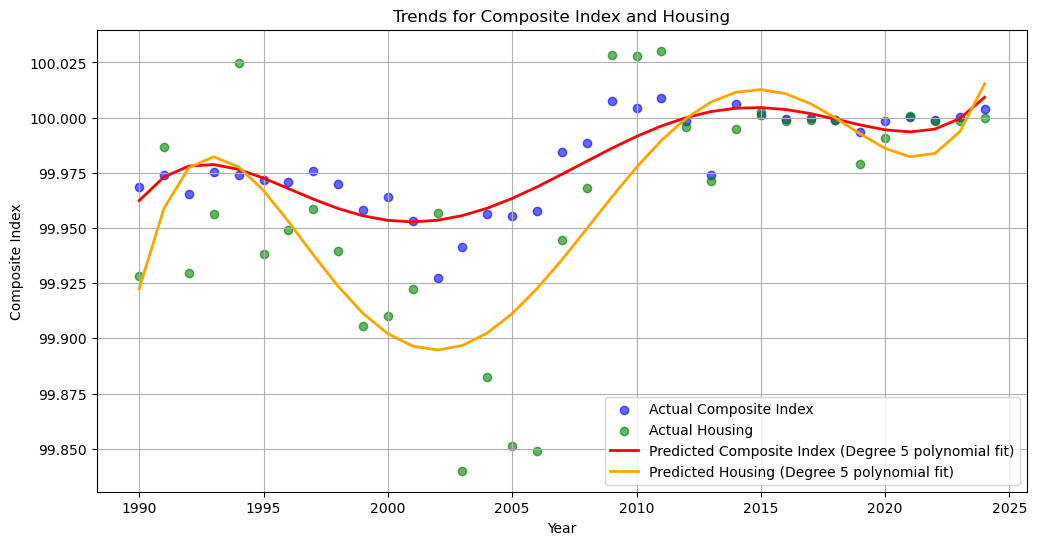

In [253]:
from sklearn.metrics import r2_score

# Aggregate data by year for both COMPOSITE_INDEX and HOUSING
composite_index_housing_by_year = data.groupby(['YEAR'])[['COMPOSITE_INDEX', 'HOUSING']].mean().reset_index()

# Handle outliers for COMPOSITE_INDEX
q1_c = composite_index_housing_by_year['COMPOSITE_INDEX'].quantile(0.25)
q3_c = composite_index_housing_by_year['COMPOSITE_INDEX'].quantile(0.75)
iqr_c = q3_c - q1_c
lower_bound_c = q1_c - 1.5 * iqr_c
upper_bound_c = q3_c + 1.5 * iqr_c

composite_index_housing_by_year.loc[
    (composite_index_housing_by_year['COMPOSITE_INDEX'] < lower_bound_c) |
    (composite_index_housing_by_year['COMPOSITE_INDEX'] > upper_bound_c), 'COMPOSITE_INDEX'
] = composite_index_housing_by_year['COMPOSITE_INDEX'].mean()

# Handle outliers for HOUSING
q1_h = composite_index_housing_by_year['HOUSING'].quantile(0.25)
q3_h = composite_index_housing_by_year['HOUSING'].quantile(0.75)
iqr_h = q3_h - q1_h
lower_bound_h = q1_h - 1.5 * iqr_h
upper_bound_h = q3_h + 1.5 * iqr_h

composite_index_housing_by_year.loc[
    (composite_index_housing_by_year['HOUSING'] < lower_bound_h) |
    (composite_index_housing_by_year['HOUSING'] > upper_bound_h), 'HOUSING'
] = composite_index_housing_by_year['HOUSING'].mean()

# Separate X (YEAR) and y (COMPOSITE_INDEX and HOUSING)
X_year = composite_index_housing_by_year[['YEAR']].values
y_ch = composite_index_housing_by_year[['COMPOSITE_INDEX', 'HOUSING']].values

degree = 5
poly_ch = PolynomialFeatures(degree=degree)
X_poly_yr = poly_ch.fit_transform(X_year)

scaler_yr = StandardScaler()
X_poly_yr_scaled = scaler_yr.fit_transform(X_poly_yr)

# Multi-output regression model
multi_output_model = LinearRegression()
multi_output_model.fit(X_poly_yr_scaled, y_ch)
trend_ch = multi_output_model.predict(X_poly_yr_scaled)

# Extract predicted trends
trend_composite = trend_ch[:, 0]
trend_housing = trend_ch[:, 1]

# Mean Absolute Errors
mae_composite = mean_absolute_error(y_ch[:, 0], trend_composite)
mae_housing = mean_absolute_error(y_ch[:, 1], trend_housing)

# R-square scores
r2_composite = r2_score(y_ch[:, 0], trend_ch[:, 0])  
r2_housing = r2_score(y_ch[:, 1], trend_ch[:, 1])    
print(f"R² composite: {r2_composite}, R² housing: {r2_housing},")

print(f"Composite Index - MAE: {mae_composite}, R²: {r2_composite}")
print(f"Housing - MAE: {mae_housing}, R²: {r2_housing}")


# Visualize both Composite Index and Housing trends on the same plot
plt.figure(figsize=(12, 6))

# Plot actual Composite Index and Housing data
plt.scatter(X_year, y_ch[:, 0], color='blue', label='Actual Composite Index', alpha=0.6)
plt.scatter(X_year, y_ch[:, 1], color='green', label='Actual Housing', alpha=0.6)

# Plot predicted trends for Composite Index and Housing
plt.plot(X_year, trend_composite, color='red', label=f'Predicted Composite Index (Degree {degree} polynomial fit)', linewidth=2)
plt.plot(X_year, trend_housing, color='orange', label=f'Predicted Housing (Degree {degree} polynomial fit)', linewidth=2)

# Customize plot
plt.xlabel('Year')
plt.ylabel('Composite Index')
plt.title('Trends for Composite Index and Housing')
plt.legend()
plt.grid(True)
plt.show()



States in Cluster 0:
0            Alabama
2            Arizona
3           Arkansas
5           Colorado
7           Delaware
9            Florida
10           Georgia
12             Idaho
13          Illinois
14           Indiana
15              Iowa
16            Kansas
17          Kentucky
18         Louisiana
21          Michigan
22         Minnesota
23       Mississippi
24          Missouri
25           Montana
26          Nebraska
27            Nevada
30        New Mexico
32    North Carolina
33      North Dakota
34              Ohio
35          Oklahoma
36            Oregon
37      Pennsylvania
39    South Carolina
40      South Dakota
41         Tennessee
42             Texas
43              Utah
45          Virginia
46        Washington
47     West Virginia
48         Wisconsin
49           Wyoming
Name: STATE_NAME, dtype: object
States in Cluster 1:
1                   Alaska
4               California
6              Connecticut
8     District of Columbia
11                  

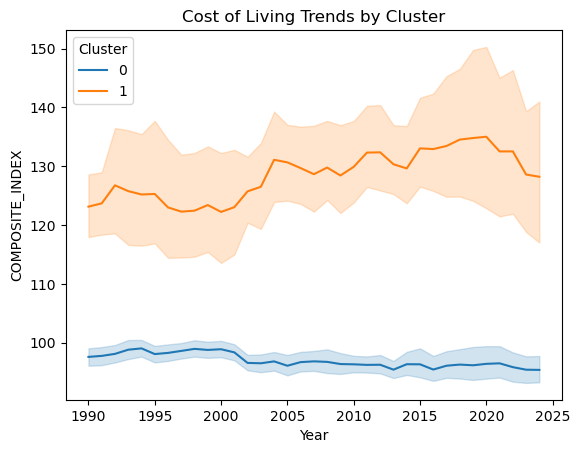

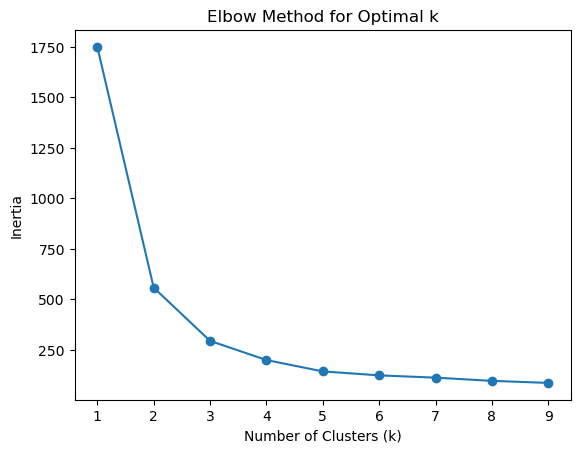

In [254]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## Use Clustering model to identify states with increasing trends

# Group by YEAR, STATE_NAME, then calculate the mean of COMPOSITE_INDEX (per state for each year)
aggregated_data = data.groupby(['YEAR', 'STATE_NAME'])['COMPOSITE_INDEX'].mean().reset_index()

# Pivot the data so each row is a state and each column is a year
clustered_data = aggregated_data.pivot(index='STATE_NAME', columns='YEAR', values='COMPOSITE_INDEX')

# Drop rows with 15 or more missing values, otherwise fill NaNs with the row mean (Composite Index)
clustered_data = clustered_data[clustered_data.isna().sum(axis=1) < 15]  # Keep rows with less than 15 NaNs
clustered_data = clustered_data.apply(lambda row: row.fillna(row.mean()), axis=1)  # Fill remaining NaNs with row mean

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustered_data)

# Set the number of clusters (k) and fit KMeans model
cluster_number = 2
kmeans = KMeans(n_clusters=cluster_number, random_state=42)
kmeans.fit(scaled_data)
clustered_data['Cluster'] = kmeans.labels_

clustered_data.reset_index(inplace=True)

# print states in each cluster
for i in range(cluster_number):
    cluster_states = clustered_data[clustered_data['Cluster'] == i]['STATE_NAME']
    print(f"States in Cluster {i}:")
    print(cluster_states)

# Melt the data to long format for visualization
melted = clustered_data.melt(id_vars=['STATE_NAME', 'Cluster'], var_name='Year', value_name='COMPOSITE_INDEX')

# Plot the trends
sns.lineplot(data=melted, x='Year', y='COMPOSITE_INDEX', hue='Cluster', legend='full')
plt.title("Cost of Living Trends by Cluster")
plt.show()

# Find out optimal cluster k value using Elbow Method 
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Elbow method shows the optimal k-value to be 2, we fit the data using 2 clusters in kMeans cluster model.
# As shown in the Cost of Living Trends by Cluster plotting graph, cluster 1 has an increasing trend. 
# States in cluster 1 have experienced increasing changes in cost of living. 
# They are Alaska, California, Connecticut, District of Columbia, Hawaii, Maryland, Massachusetts, 
# New Hampshire, New Jersey, New York, Rhode Island and Vermont


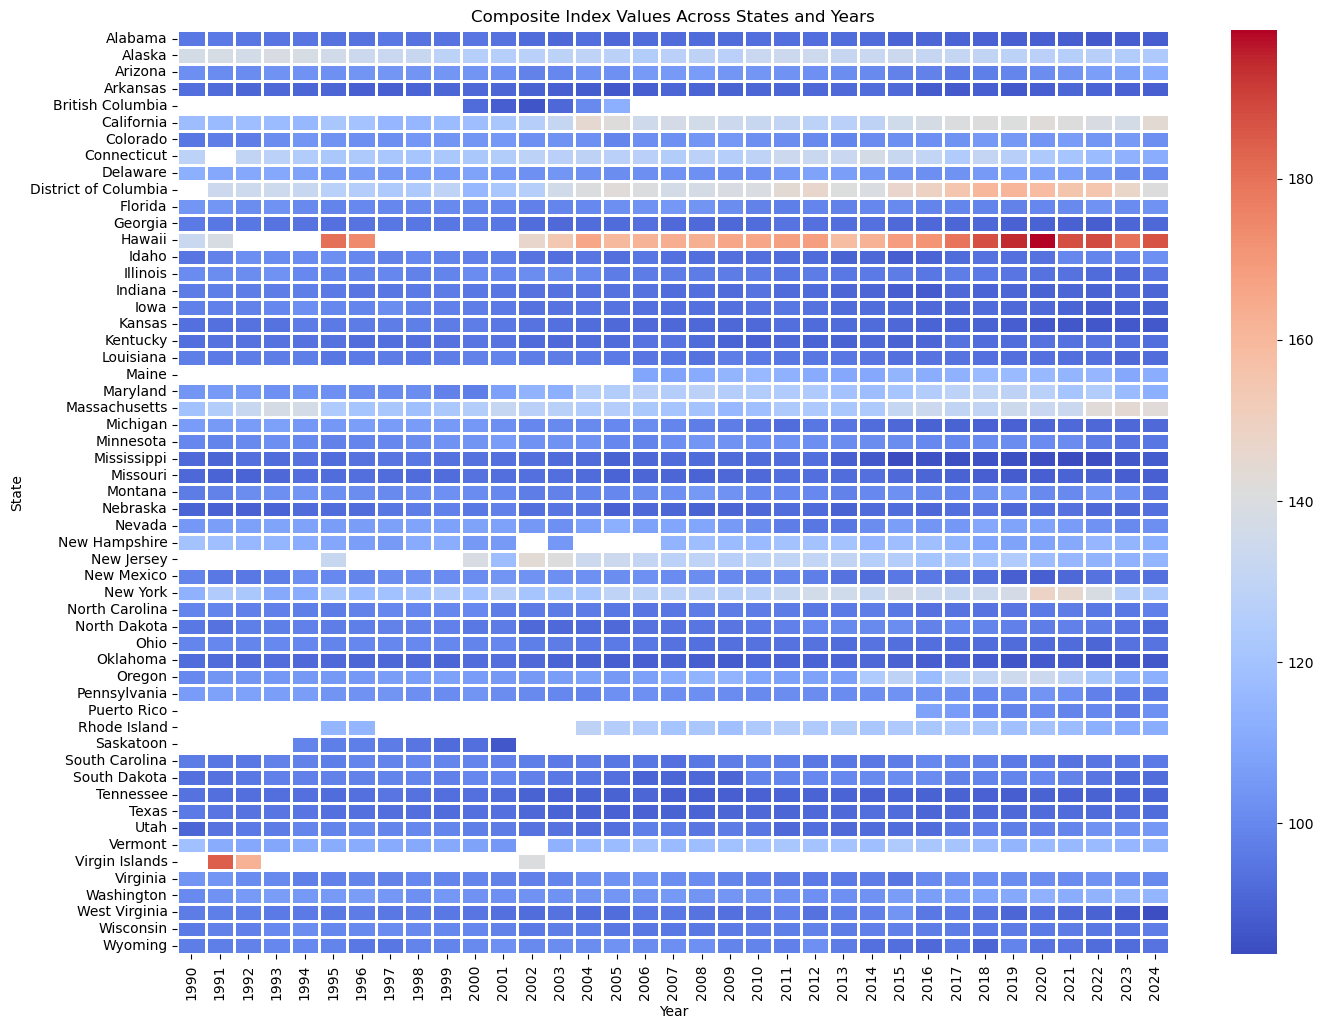

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

## Heatmap to visualize the composite_index values for all states over all years

# Pivot the data to create a matrix where rows are states, columns are years, and values are composite_index
heatmap_data = data.pivot_table(index='STATE_NAME', columns='YEAR', values='COMPOSITE_INDEX')

plt.figure(figsize=(16, 12))
# sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=1)
plt.title('Composite Index Values Across States and Years')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

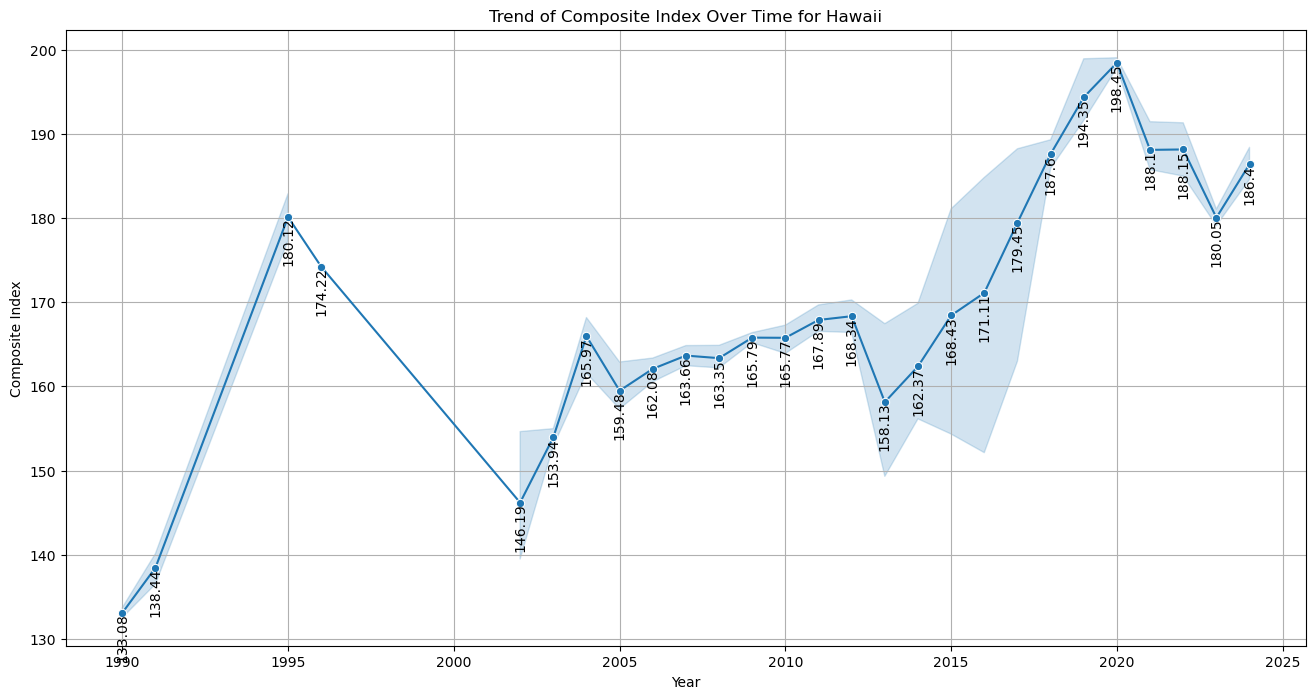

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot to see trend of composite_index for one state overtime

# Filter data for a specific state 
state_name = 'Hawaii'
state_data = data[data['STATE_NAME'] == state_name]

# Calculate the average composite_index for each year
average_values = state_data.groupby('YEAR')['COMPOSITE_INDEX'].mean()

# Create a line plot for composite_index over time (each point is the average composite_index)
plt.figure(figsize=(16, 8))
sns.lineplot(x='YEAR', y='COMPOSITE_INDEX', data=state_data, marker='o')
plt.title('Trend of Composite Index Over Time for ' + state_name)
plt.xlabel('Year')
plt.ylabel('Composite Index')
plt.grid(True)

# # Display the composite_index values on the line plot
for year, value in average_values.items():
    plt.text(year, value, round(value, 2), ha='center', va='top', rotation=90)
    
plt.show()

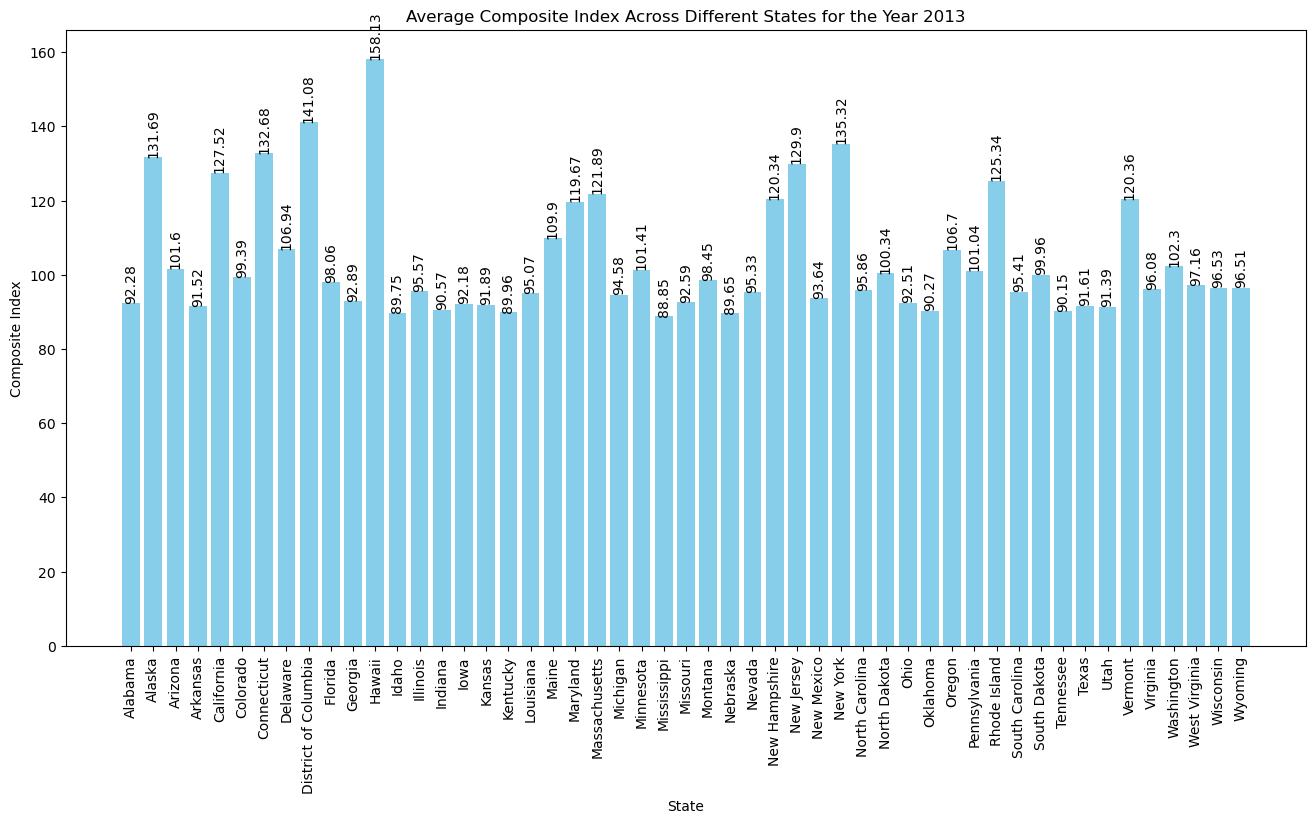

In [257]:
import matplotlib.pyplot as plt

# Bar chart to compare the composite_index values across different states for a specific year

target_year = 2013
year_data = data[data['YEAR'] == target_year]

# Group the data by state_name and calculate the average composite_index for the year
average_index_by_state = year_data.groupby('STATE_NAME')['COMPOSITE_INDEX'].mean().reset_index()

# Create a bar chart to compare composite_index values across different states for the year
plt.figure(figsize=(16, 8))
bars = plt.bar(average_index_by_state['STATE_NAME'], average_index_by_state['COMPOSITE_INDEX'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Composite Index')
plt.title(f'Average Composite Index Across Different States for the Year {target_year}')
plt.xticks(rotation=90)

# Display the composite_index values on the bars
for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y_val, round(y_val, 2), ha='center', va='bottom', rotation=90)
    
plt.show()